In [271]:
import torch
import torchvision
import torchvision.transforms as transforms
import cv2
import numpy as np
from torchvision import models
import matplotlib.pyplot as plt
from torchinfo import summary

default_device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(default_device)

cuda


# Not revelant stuff

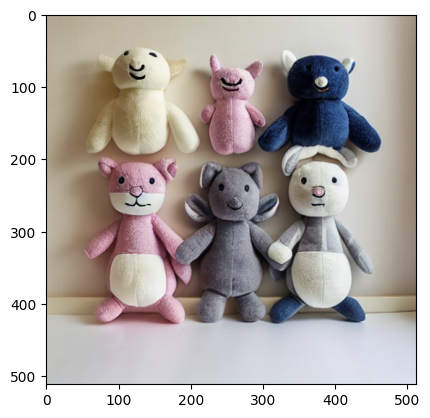

In [272]:
img = cv2.imread(r"C:\Users\rotte\Downloads\synthetic_images\images\Plushie_0.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
im = img

In [436]:
transform1 = transforms.Compose([
    transforms.ToTensor(),
])

processed = transform1(img)
processed.shape

In [559]:
model = models.detection.ssdlite320_mobilenet_v3_large(weights=torchvision.models.detection.SSDLite320_MobileNet_V3_Large_Weights.DEFAULT)
#model.load_state_dict(torch.load('model_statedict.pth'))    

In [ ]:
model.to(default_device)
model.eval()


pred = model(processed.unsqueeze(axis=0).to(default_device))

output = np.swapaxes(processed,0,1)
output = np.swapaxes(output,1,2)
output = output.numpy()

final = output * 255
final = np.ascontiguousarray(final, dtype=np.int32)

In [ ]:
#To filter only plushies
plushOnly = [[],[]]
for i in range(len(pred[0]['labels'])):
    if pred[0]['labels'][i] == 88 and pred[0]['scores'][i]>0.4:
        plushOnly[0].append(pred[0]['boxes'][i].cpu().detach())
        plushOnly[1].append(pred[0]['scores'][i].cpu().detach())

plushOnly = plushOnly
s = torch.stack(plushOnly[0])

# Processing data


In [ ]:
#Drawing predictions with n objects onto image, out has shape [[boxes], [score]]

def draw(image, out):
    for i in range(len(out[0])):
        if out[1][i] < 0.1:
            return image
        j = out[0][i]
        cv2.rectangle(image,
                (int(j[0]), int(j[1])),
                (int(j[2]), int(j[3])),
                (0,200,0), 2
                )
        
        #if you want to add text
        '''
        cv2.putText(image,
                'text',
                (int(j[0]), int(j[1])-5),
                cv2.FONT_HERSHEY_SIMPLEX,
                2, (0,200,0), 3)
        '''
    return image

In [ ]:
image = draw(final, plushOnly)

In [ ]:
#to refresh the written img, unnecesary if first time running draw()
img = cv2.imread(r"C:\Users\rotte\Downloads\synthetic_images\images\Plushie_0.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im = img

processed = transform1(img)
output = np.swapaxes(processed,0,1)
output = np.swapaxes(output,1,2)
output = output.numpy()

final = output * 255
final = np.ascontiguousarray(final, dtype=np.int32)

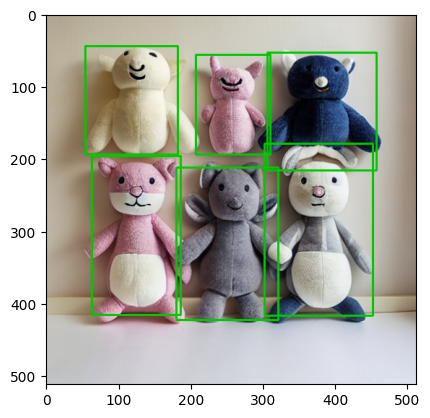

In [ ]:
plt.imshow(image)

In [ ]:
!pip install torchinfo
from torchinfo import summary
summary(model, input_size=(1,3,224,224))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                                       Output Shape              Param #
SSD                                                          [10, 4]                   --
├─GeneralizedRCNNTransform: 1-1                              [1, 3, 320, 320]          --
├─SSDLiteFeatureExtractorMobileNet: 1-2                      [1, 128, 1, 1]            --
│    └─Sequential: 2-1                                       --                        --
│    │    └─Sequential: 3-1                                  [1, 672, 20, 20]          869,096
│    │    └─Sequential: 3-2                                  [1, 480, 10, 10]          751,416
│    └─ModuleList: 2-2                                       --                        --
│    │    └─Sequential: 3-3                                  [1, 512, 5, 5]            258,304
│    │    └─Sequential: 3-4                                  [1, 256, 3, 3]            100,480
│    │    └─Sequential: 3-5                                  [1, 256, 2, 2]

From the summary above, I think only the SSDLite Head layers will require fine tuning, I doubt the feature extracting parts need work as the model is sufficiently trained to pick up edges

# Prepping data for training



In [ ]:
import os
import glob
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]


In [ ]:
#get all filenames
all_anno = glob.glob(os.path.join(r"C:\Users\rotte\Downloads\synthetic_labels\labels", "*.txt"))
all_anno = sorted(all_anno, key=natural_keys)
#extract text from files
labels = []
for i in all_anno:
    temp =[]
    with open(i) as f:
        line = ([line.rstrip() for line in f])
        for l in line:
            box = [float(s) for s in l.split(' ')]
            temp.append(np.array(box, dtype=float))
    labels.append(temp)

#list of image filenames to extract in dataloader
filenames = next(os.walk(r"C:\Users\rotte\Downloads\synthetic_images\images"), (None, None, []))[2]
filenames = sorted(filenames, key=natural_keys)


In [ ]:
#fast check
print(len(all_anno), len(filenames))

2843 2843


In [316]:
#custom dataset. This shit is a mess, doesnt work for batchsize != 1
class PlushDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, labels, filenames, transform=None):
        """
        Arguments:
            txt_file (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.filenames = filenames

    def __len__(self):
        #tells dataloader when to raise stopiteration
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.root_dir,
                            filenames[idx])
        
        image = cv2.imread(img_name)
        labels = self.labels[idx]
        y = labels

        
        sample = {'x': image, 'y': y}
        return sample

def collate_fn(data):

    batchsize = len(data)
    imgs, boxes = [], []

    for i in range(batchsize):
        imgs.append(data[i]['x'])
        boxes.append(data[i]['y'])


    return imgs, boxes

# Helper functions

In [499]:
#yolo to box and vice versa
def yolo2box(size, yolof):
    img_x = size[0]
    img_y = size[1]
    x = yolof[0]*img_x
    y = yolof[1]*img_y
    w = yolof[2]*img_x
    h = yolof[3]*img_y
    x1, y1 = x-w/2, y-h/2
    x2, y2 = x+w/2, y+h/2
    return torch.stack([x1, y1, x2, y2])

#size is x by y, box is [x1, x2, y1, y2]
def convert(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[2])/2.0
    y = (box[1] + box[3])/2.0
    w = box[2] - box[0]
    h = box[3] - box[1]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return torch.FloatTensor([x,y,w,h])

#find closest node in array by vectorisation
def closest_node(node, nodes):
    deltas = nodes - node
    dist_2 = torch.einsum('ij,ij->i', deltas, deltas)
    return torch.argmin(dist_2)

#pair each label with a pred whose centre is closest
def pair(pred, labels):
    order = []
    predyolo = []
    for i in labels:
        order.append(closest_node(i[:2], pred[:,:2]))
    return order

#generalised IOU
def giou_loss(
    boxes1: torch.Tensor,
    boxes2: torch.Tensor,
    reduction: str = "mean",
    eps: float = 1e-7,
) -> torch.Tensor:
    """
    Generalized Intersection over Union Loss (Hamid Rezatofighi et. al)
    https://arxiv.org/abs/1902.09630

    Gradient-friendly IoU loss with an additional penalty that is non-zero when the
    boxes do not overlap and scales with the size of their smallest enclosing box.
    This loss is symmetric, so the boxes1 and boxes2 arguments are interchangeable.

    Args:
        boxes1, boxes2 (Tensor): box locations in XYXY format, shape (N, 4) or (4,).
        reduction: 'none' | 'mean' | 'sum'
                 'none': No reduction will be applied to the output.
                 'mean': The output will be averaged.
                 'sum': The output will be summed.
        eps (float): small number to prevent division by zero
    """

    x1, y1, x2, y2 = boxes1.unbind(dim=-1)
    x1g, y1g, x2g, y2g = boxes2.unbind(dim=-1)

    assert (x2 >= x1).all(), "bad box: x1 larger than x2"
    assert (y2 >= y1).all(), "bad box: y1 larger than y2"

    # Intersection keypoints
    xkis1 = torch.max(x1, x1g)
    ykis1 = torch.max(y1, y1g)
    xkis2 = torch.min(x2, x2g)
    ykis2 = torch.min(y2, y2g)

    intsctk = torch.zeros_like(x1)
    mask = (ykis2 > ykis1) & (xkis2 > xkis1)
    intsctk[mask] = (xkis2[mask] - xkis1[mask]) * (ykis2[mask] - ykis1[mask])
    unionk = (x2 - x1) * (y2 - y1) + (x2g - x1g) * (y2g - y1g) - intsctk
    iouk = intsctk / (unionk + eps)

    # smallest enclosing box
    xc1 = torch.min(x1, x1g)
    yc1 = torch.min(y1, y1g)
    xc2 = torch.max(x2, x2g)
    yc2 = torch.max(y2, y2g)

    area_c = (xc2 - xc1) * (yc2 - yc1)
    miouk = iouk - ((area_c - unionk) / (area_c + eps))

    loss = 1 - miouk

    if reduction == "mean":
        loss = loss.mean() if loss.numel() > 0 else 0.0 * loss.sum()
    elif reduction == "sum":
        loss = loss.sum()

    return loss


#basically GIOU but pairing the pred and labels first
def losss(pred, labels): #takes in tensors of shape (n, 4) and (n, 4) with xyxy format
    predorder = pair(pred, labels)
    predordered = pred[torch.stack(predorder)]
    return giou_loss(predordered, labels)

# Training

In [439]:
dataset = PlushDataset(root_dir=r"C:\Users\rotte\Downloads\synthetic_images\images", labels = labels, filenames = filenames)
dataloader = torch.utils.data.DataLoader(dataset, collate_fn=collate_fn)

# Training loop

In [561]:
def train(net,train_loader,epochs=3,lr=1e-3,transform=transform1):
    lossgraph = []
    optimizer = torch.optim.Adam(net.parameters(),lr=lr)
    for epoch in range(epochs):
        total_loss,acc,count = 0,0,1e-7
        model.eval()
        model.to(default_device)
        for i, (x,y) in enumerate(train_loader):
            imgsize = x[0].shape[:2]
            optimizer.zero_grad()
            
            #to convert xywh to xyxy
            y = torch.stack([torch.from_numpy(item).float() for item in y[0]])[:,1:]
            newy = []
            for j in range(len(y)):
                newy.append(yolo2box([512,512], y[j]))
            lbls = torch.stack(newy).to(default_device)
            
            net.detections_per_img = len(lbls)
            out = net(transform(x[0]).unsqueeze(dim=0).to(default_device))
            
            #Loss calculation 
            pred = out[0]['boxes']
            bboxloss = losss(pred, lbls)
            bboxloss.backward()
            optimizer.step()

            total_loss+=bboxloss
            if i%100 == 0 and i!=0:
                lossgraph.append(total_loss.item()/i)
            
            if i%200 == 0 and i!=0:
                lossgraph
                print(i%100)
                print("Epoch {}, minibatch {}: mean loss = {} pic loss = {}".format(epoch, i, total_loss.item()/i, bboxloss))
        
    return lossgraph

In [562]:
losses = train(model, dataloader)

0
Epoch 0, minibatch 200: mean loss = 0.4284238052368164 pic loss = 0.1071895956993103


In [551]:
torch.save(model.state_dict(), 'model_statedict.pth')
torch.save(model, 'model.pth')
